In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

from gradvi.tests import toy_data
from gradvi.tests import toy_priors
from gradvi.inference import Trendfiltering
from gradvi.inference import LinearRegression
from gradvi.models import basis_matrix as gvbm
from gradvi.models.basis_matrix.bm_trendfiltering import center_and_scale_tfbasis

In [14]:
np.random.seed(100)

n = 1024
data = dict()
degree = 2
nknots = 10
strue  = 0.1
knots  = np.linspace(0, 1, nknots+2)[1:-1]


x = np.linspace(0, 1, n)
data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                signal = "normal", seed = 100,
                include_intercept = False)

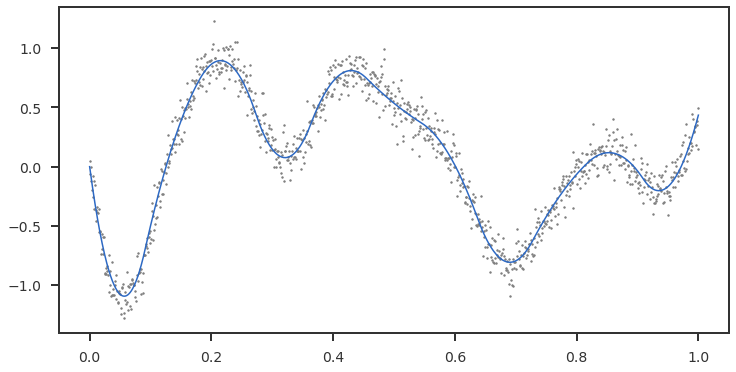

In [15]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'gray')
ax1.plot(data.x, data.ytrue)
plt.show()

In [37]:
prior = toy_priors.get_ash_scaled(k = 20, sparsity = 0.9, skbase = 200)

In [38]:
gv = LinearRegression(obj = 'reparametrize', maxiter = 1000, fit_intercept = False)

Hscale, _, _ = gvbm.center_and_scale_tfbasis(data.H)
Hinv_scaled  = gvbm.trendfiltering_inverse_scaled(n, degree)
b_init = np.dot(Hinv_scaled, data.ytrue)
gv.fit(Hscale, data.y, prior, b_init = b_init)
gv_ypred = np.dot(Hscale, gv.coef)

# b_init = np.dot(data.Hinv, data.ytrue)
# gv.fit(data.H, data.y, prior, b_init = b_init)
# gv_ypred = np.dot(data.H, gv.coef)

itrtime = gv._res.optim_time / gv.nfev
print (n, gv.niter, gv.nfev, gv.intercept, f"{itrtime:g}")

1024 1000 1349 0 0.00371909


In [43]:
gv1 = Trendfiltering(obj = 'reparametrize', maxiter = 1000, scale_tfbasis = False)
gv1.fit(data.y, degree, prior, y_init = data.ytrue)
itrtime1 = gv1._res.optim_time / gv1.nfev
print (n, gv1.niter, gv1.nfev, gv1.intercept, f"{itrtime1:g}")

1024 467 685 0 0.00660122


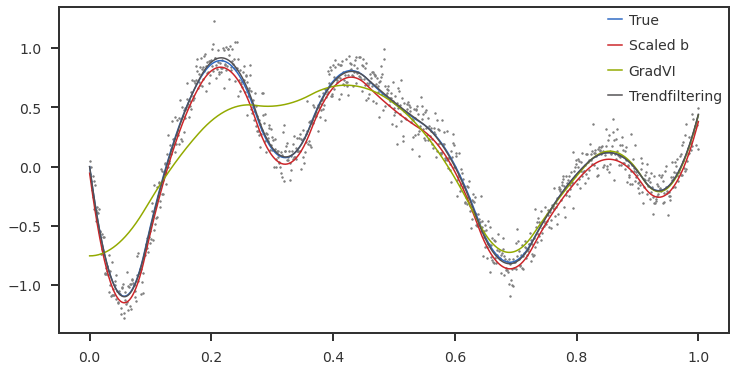

In [44]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'gray')
ax1.plot(data.x, data.ytrue, label = 'True')
ax1.plot(data.x, np.dot(Hscale, b_init), label = 'Scaled b')
ax1.plot(data.x, gv_ypred, label = 'GradVI')
ax1.plot(data.x, gv1.ypred, label = 'Trendfiltering')
ax1.legend()
plt.show()

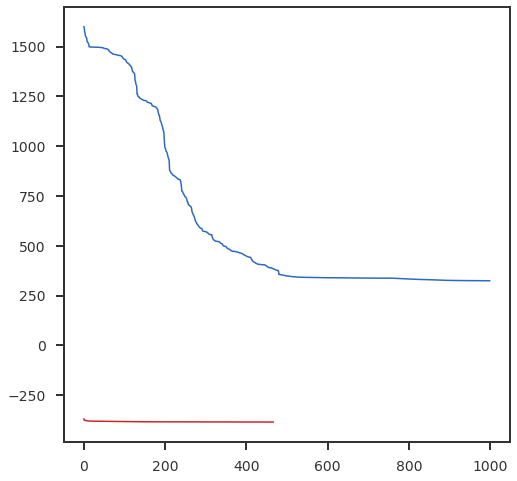

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(gv.niter), gv.elbo_path)
ax1.plot(np.arange(gv1.niter), gv1.elbo_path)
plt.show()

In [9]:
gv._dj

array([1.024e+03, 1.023e+03, 1.022e+03, ..., 3.000e+00, 2.000e+00,
       1.000e+00])